# Recommendation System Project: IBM Community


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras + Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` To ensure data consistency and prepare the dataset for further processing, we first check for missing values. If any missing values are found, we take appropriate actions based on the column affected - Missing email values: If the email column contains missing entries, we replace them with the placeholder string "unknown_user" to retain row integrity and enable downstream user identification logic.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
print(f"Number of Null email values is: "+ str(df.email.isna().sum()))

Number of Null email values is: 17


In [4]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [5]:
# Filling email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [6]:
# Checking if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` We analyze how many articles each user interacts with to understand engagement patterns.

**Step 1**: Count the number of interactions per user.

**Step 2**: Display descriptive statistics.

**Step 3**: Visualize the distribution with a histogram.

In [7]:
df['article_id'].value_counts()

article_id
1429    937
1330    927
1431    671
1427    643
1364    627
       ... 
1344      1
984       1
1113      1
675       1
662       1
Name: count, Length: 714, dtype: int64

In [8]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_article_counts = df.groupby('email')['article_id'].nunique()
desc_stats = user_article_counts.describe()
print("Descriptive Statistics:")
print(desc_stats)

Descriptive Statistics:
count    5149.000000
mean        6.541464
std         9.990112
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: article_id, dtype: float64


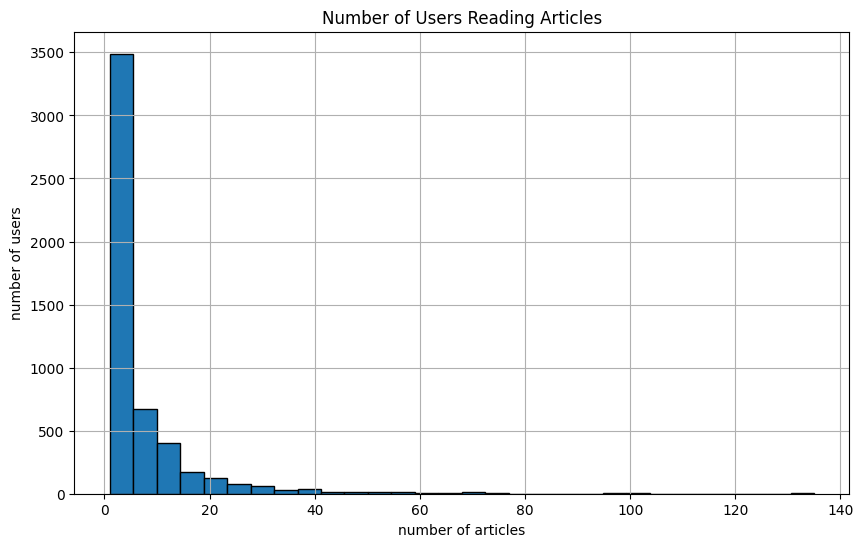

In [9]:
# Create a plot of the number of articles read by each user
plt.figure(figsize=(10,6))
plt.hist(user_article_counts, bins=30, edgecolor='black')
plt.grid(True)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

Descriptive Statistics:
count    714.000000
mean      47.173669
std       65.467790
min        1.000000
25%        7.000000
50%       21.500000
75%       59.000000
max      467.000000
Name: email, dtype: float64


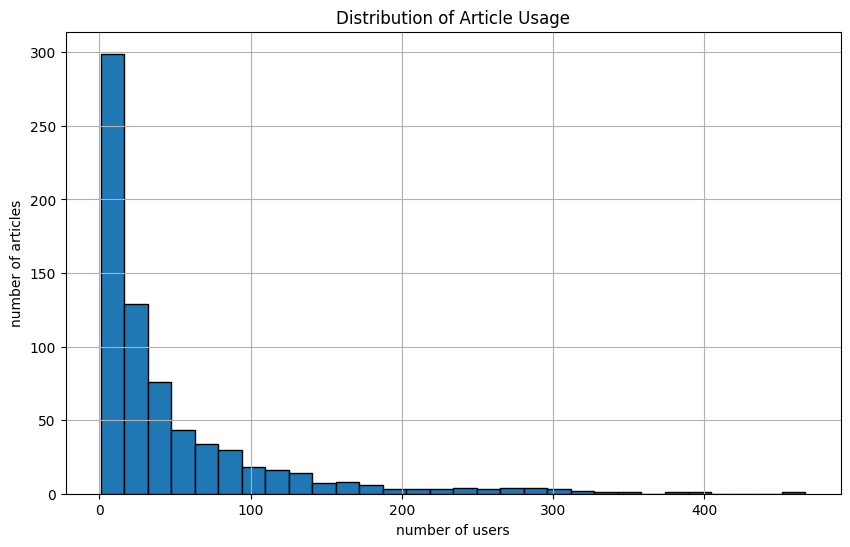

In [10]:
# Create a plot of the number of times each article was read
article_user_counts = df.groupby('article_id')['email'].nunique()
desc_stats = article_user_counts.describe()
print("Descriptive Statistics:")
print(desc_stats)

plt.figure(figsize=(10,6))
plt.hist(article_user_counts, bins=30, edgecolor='black')
plt.grid(True)
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [11]:
# Fill in the median and maximum number of user_article interactions below

median_val =  user_article_counts.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =  df.groupby('email')['article_id'].count().max() # The maximum number of user-article interactions by any 1 user is ______.
print(median_val, max_views_by_user)

3.0 364


`3.` We compute key metrics to understand the structure of the dataset:

**a**. Unique articles with interactions: Articles that have at least one user interaction.

**b**. Total unique articles: All distinct articles present in the dataset, regardless of interaction.

**c**. Unique users: Number of users with recorded interactions (excluding null user IDs).

**d**. Total interactions: Total number of user-article interaction events recorded.

In [12]:
unique_articles =  df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles =  len(article_user_counts.index )# The number of unique articles on the IBM platform
unique_users =  len(user_article_counts.index) # The number of unique users
user_article_interactions =  len(df) # The number of user-article interactions
print(unique_articles)

714


`4.` To identify the most popular content, we determine:

- The **article_id** with the highest number of user interactions.

- The corresponding number of views.

In consultation with company leadership, we adopt the email_mapper function to handle missing user IDs. All null emails are mapped to a single identifier, "unknown_user", which is assumed to represent one anonymous user.

In [13]:
most_viewed_id = df['article_id'].value_counts().idxmax()
most_viewed_article_id = most_viewed_id #f"{most_viewed_id:.0f}"  # The most viewed article in the dataset as a string with one value following the decimal 
max_views =  df['article_id'].value_counts().max() # The most viewed article in the dataset was viewed how many times?
print(most_viewed_article_id, max_views)

1429 937


In [14]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [15]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles_index = list(df['article_id'].value_counts().index)
    top_articles_index = top_articles_index[:n]
    top_articles = df[df['article_id'].isin(top_articles_index)]['title'].drop_duplicates().tolist()

    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles_index = list(df['article_id'].value_counts().index)
    top_articles_index = top_articles_index[:n]
 
    return top_articles_index # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [18]:
# Test function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Use email or user_id as user identifier (assume email here)
    df_clean = df.dropna(subset=['user_id'])
    
    # Add a value column to mark interaction
    df_clean['interaction'] = 1
    
    # Create the pivot table (user-item matrix)
    user_item = df_clean.pivot_table(index='user_id', columns='article_id',
                                     values='interaction', fill_value=fill_value)

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()#

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity#

In [23]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    
    # compute similarity of each user to the provided user
    target_vector = user_item.loc[user_id].values
    similarities = user_item.dot(target_vector)
    
    # sort by similarity
    similarities_sorted = similarities.sort_values(ascending=False)
    # remove the own user's id
    similarities_sorted = similarities_sorted.drop(user_id)

    # create list of just the ids
    most_similar_users = similarities_sorted.index.tolist()
    # create list of just the similarities
    similarities_sorted_values = similarities_sorted.values.tolist()
    if include_similarity:
        return [[int(uid), sim] for uid, sim in zip(user_id_sorted, similarities_sorted_values)]
    else:
        return most_similar_users # return a list of the users in order from most to least similar
        

In [24]:
# Spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Ensure article_ids are numeric and consistent with df['article_id']
    article_ids = [int(float(aid)) for aid in article_ids]
    
    # Drop duplicates to avoid repeated titles
    article_map = df.drop_duplicates('article_id')[['article_id', 'title']]
    
    # Filter rows where article_id is in the list
    matched_titles = article_map[article_map['article_id'].isin(article_ids)]
    
    # Return list of titles in the same order as input ids
    id_to_title = dict(zip(matched_titles['article_id'], matched_titles['title']))
    article_names = [id_to_title.get(int(float(aid))) for aid in article_ids if int(float(aid)) in id_to_title]
    
    return article_names

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """

    # Ensure article_ids are int (to match column names)
    article_ids = [int(float(aid)) for aid in article_ids]
    
    # Count non-zero entries (i.e., interactions) per article
    article_counts = [[aid, int(user_item[aid].sum())] 
                      for aid in article_ids if aid in user_item.columns]

    # Sort by number of users descending
    ranked_article_unique_counts = sorted(article_counts, key=lambda x: x[1], reverse=True)
    
    return ranked_article_unique_counts
    

def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Get article IDs the user interacted with (i.e., where value == 1)
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    
    # Ensure all article_ids are int for matching with df
    article_ids = [int(float(aid)) for aid in article_ids]
    
    # Get corresponding article names using helper function
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # Get articles the user has already seen
    user_seen_articles, _ = get_user_articles(user_id, user_item)
    
    # Find most similar users
    similar_users = find_similar_users(user_id, user_item)

    # Initialize a set to track recommendations
    recs = []
    recs_set = set()
    
    # Loop through similar users to gather unseen articles
    for sim_user in similar_users:
        sim_user_articles, _ = get_user_articles(sim_user, user_item)
        
        # Add unseen articles to recs
        for aid in sim_user_articles:
            if aid not in user_seen_articles and aid not in recs_set:
                recs.append(aid)
                recs_set.add(aid)
                if len(recs) >= m:
                    break
        if len(recs) >= m:
            break

    return recs # return your recommendations for this user_id    

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [27]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [28]:
# Test functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    # Compute similarity scores (dot product)
    target_vector = user_item.loc[user_id].values
    similarities = user_item.dot(target_vector)
    
    # Drop self-similarity
    similarities = similarities.drop(user_id)
    
    # Compute number of interactions per user
    num_interactions = user_item.sum(axis=1)
    
    # Create DataFrame
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarities.index,
        'similarity': similarities.values,
        'num_interactions': num_interactions.loc[similarities.index].values
    })
    
    # Sort by similarity DESC, then num_interactions DESC
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions', 'neighbor_id'],
        ascending=[False, False, True])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # Articles the user has already seen
    user_seen, _ = get_user_articles(user_id)
    
    # Get sorted similar users with num_interactions
    neighbors_df = get_top_sorted_users(user_id)
    
    recs = []
    recs_set = set()
    
    # Loop through neighbors
    for _, row in neighbors_df.iterrows():
        neighbor_id = row['neighbor_id']
        neighbor_articles, _ = get_user_articles(neighbor_id)
        
        # Recommend unseen articles
        for article_id in neighbor_articles:
            if article_id not in user_seen and article_id not in recs_set:
                recs.append(article_id)
                recs_set.add(article_id)
                if len(recs) >= m:
                    break
        if len(recs) >= m:
            break

    # Rank articles by total number of unique user interactions
    if len(recs) > m:
        ranked_articles = get_ranked_article_unique_counts(recs, user_item)
        recs = [aid for aid, _ in ranked_articles][:m]
        
    return recs, get_article_names(recs) # return your recommendations for this user_id

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12, 14, 29, 33, 43, 51, 109, 111, 130, 142]

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'experience iot with coursera', 'using brunel in ipython/jupyter notebooks', 'deep learning with tensorflow course by big data university', 'modern machine learning algorithms', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', "feature importance and why it's important", 'neural networks for beginners: popular types and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

      neighbor_id  similarity  num_interactions
3931         3933        35.0              35.0
      neighbor_id  similarity  num_interactions
47             49         5.0             101.0
3695         3697         5.0             100.0
96             98         5.0              97.0
3762         3764         5.0              97.0
21             23         4.0             135.0
3780         3782         4.0             135.0
4783         4785         4.0              62.0
19             21         4.0              61.0
288           290         4.0              58.0
2980         2982         4.0              58.0
      neighbor_id  similarity  num_interactions
3868         3870        74.0              75.0
3780         3782        39.0             135.0
22             23        38.0             135.0
201           203        33.0              96.0
4457         4459        33.0              96.0
48             49        29.0             101.0
3695         3697        29.0           

In [32]:
### Tests with a dictionary of results
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user2_6th_sim = 3782 # Find the 6th most similar user to user 2
user131_10th_sim = 3910 # Find the 10th most similar user to user 131

In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

Oops!  Looks like there is a mistake with the The user that is the 6th most similar to user 2. key in your dictionary.  The answer should be 3586.  Try again.
Oops!  Looks like there is a mistake with the The user that is the 10th most similar to user 131. key in your dictionary.  The answer should be 383.  Try again.


In [34]:
# There might be an error in the test. It is not plausible why the test fail.
neighbors = get_top_sorted_users(2)
sim_3586 = neighbors[neighbors['neighbor_id'] == 3586]['similarity'].values[0]
print(f"Similarity between user 2 and user 3586: {sim_3586}")
print('Is the similarity calculated correct?')
print(user_item.loc[2].dot(user_item.loc[3586]) == 2.0)
print('How many articles user 3586 interacted with:')
print(user_item.loc[3586].sum())
print('How many articles user 3782 interacted with:')
print(user_item.loc[3782].sum())

Similarity between user 2 and user 3586: 2.0
Is the similarity calculated correct?
True
How many articles user 3586 interacted with:
4.0
How many articles user 3782 interacted with:
135.0


In [35]:
neighbors = get_top_sorted_users(131)
sim_383 = neighbors[neighbors['neighbor_id'] == 383]['similarity'].values[0]
print(f"Similarity between user 131 and user 383: {sim_383}")
print('Is the similarity calculated correct?')
print(user_item.loc[131].dot(user_item.loc[383]) == 18)
print('How many articles user 383 interacted with:')
print(user_item.loc[383].sum())
print('How many articles user 3910 interacted with:')
print(user_item.loc[3910].sum())

Similarity between user 131 and user 383: 18.0
Is the similarity calculated correct?
True
How many articles user 383 interacted with:
32.0
How many articles user 3910 interacted with:
60.0


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:
For a new user, we cannot use any of the collaborative filtering functions above since they depend on past interactions. A better approach is to:
- Recommend the most popular articles system-wide, or
- Use content-based filtering or onboarding questions to match user preferences to articles

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [36]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [37]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [38]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   user_id     45993 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


In [40]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [41]:
# unique articles
df_unique_articles = df['title'].unique()
df_unique_articles_ids = df['article_id'].unique()

In [42]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf) # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

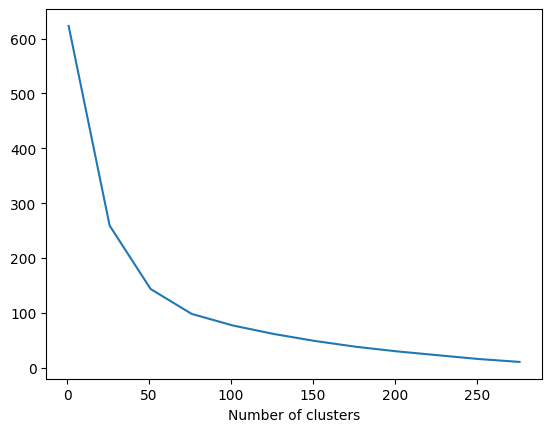

In [43]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [44]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    # Your code here, same as parameters above
    n_clusters = 300,
    max_iter = 50,
    n_init = 5,
    random_state = 42,
    ).fit(X_lsa)

In [45]:
kmeans

,n_clusters,300
,init,'k-means++'
,n_init,5
,max_iter,50
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [46]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = dict(zip(df_unique_articles_ids, kmeans.labels_))
 # Map article_id to cluster label
df['title_cluster'] = df['article_id'].map(article_cluster_map)# apply map to create title clusters

In [47]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[  0,   3],
       [  1,  49],
       [  2,   7],
       [  3,   1],
       [  4,   1],
       [  5,  25],
       [  6,  19],
       [  7,  18],
       [  8,  20],
       [  9,  13],
       [ 10,   1],
       [ 11,   1],
       [ 12,  11],
       [ 13,   2],
       [ 14,  22],
       [ 15,  19],
       [ 16,   3],
       [ 17,   3],
       [ 18,   4],
       [ 19,   1],
       [ 20,  10],
       [ 21,  24],
       [ 22,   5],
       [ 23,   4],
       [ 24,   5],
       [ 25,   4],
       [ 26,   9],
       [ 27,   3],
       [ 28,   4],
       [ 29,   5],
       [ 30,   4],
       [ 31,   1],
       [ 32,   1],
       [ 33,   1],
       [ 34,   1],
       [ 35,   1],
       [ 36,   6],
       [ 37,   2],
       [ 38,   3],
       [ 39,   1],
       [ 40,   3],
       [ 41,   5],
       [ 42,   3],
       [ 43,   2],
       [ 44,   2],
       [ 45,   1],
       [ 46,   5],
       [ 47,   6],
       [ 48,   1],
       [ 49,   3],
       [ 50,   1],
       [ 51,   2],
       [ 52,

In [48]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Get the cluster label of the input article
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].values
    if len(title_cluster) == 0:
        return []  # article not found
    
    title_cluster = title_cluster[0]
    
    # Get all article_ids in the same cluster
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()
    
    # Remove the input article_id
    articles_in_cluster = [aid for aid in articles_in_cluster if aid != article_id]
    
    return articles_in_cluster

In [49]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Step 1: Get articles in the same cluster
    similar_articles = get_similar_articles(article_id)
    
    # Step 2: Rank similar articles by number of unique user interactions
    ranked_similar = get_ranked_article_unique_counts(similar_articles)
    
    # Step 3: Select top n articles
    n_ranked_similar_articles = [aid for aid, _ in ranked_similar[:n]]
    
    # Step 4: Get corresponding article names
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    
    return n_ranked_similar_articles, n_ranked_article_names

In [50]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 693, 48, 428]
['data tidying in data science experience', 'better together: spss and data science experience', 'data science experience documentation', 'data science experience demo: modeling energy usage in nyc']


In [51]:
def debug_make_content_recs(article_id, df=df, user_item=user_item):
    print("✅ Checking article exists in df:")
    print(df[df['article_id'] == article_id][['article_id', 'title', 'title_cluster']])

    print("\n✅ Checking articles in same cluster:")
    similar_articles = get_similar_articles(article_id, df)
    print(similar_articles)

    print("\n✅ Checking user interaction counts:")
    print(get_ranked_article_unique_counts(similar_articles, user_item))

debug_make_content_recs(25)


✅ Checking article exists in df:
       article_id                                 title  title_cluster
9479           25  creating the data science experience             82
10189          25  creating the data science experience             82
11369          25  creating the data science experience             82
25516          25  creating the data science experience             82
26434          25  creating the data science experience             82
29792          25  creating the data science experience             82
30392          25  creating the data science experience             82
32538          25  creating the data science experience             82
33931          25  creating the data science experience             82
34214          25  creating the data science experience             82
37178          25  creating the data science experience             82
41806          25  creating the data science experience             82
44554          25  creating the data science

In [52]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

**Text Vectorization**
Each unique article title is transformed into a numerical vector using TF-IDF vectorization, which captures the importance of words across all titles while ignoring common stop words.

**Dimensionality Reduction (LSA)**
The high-dimensional TF-IDF vectors are then reduced using Truncated SVD (Latent Semantic Analysis) to capture latent topic relationships in a more compact representation.

**Clustering with KMeans**
These reduced vectors are clustered using KMeans, grouping similar articles based on their semantic content.

**Recommendation Logic**
- When a user views an article, we look up its cluster and recommend other articles from the same cluster.
- To improve recommendation quality, we rank those articles by popularity (number of unique users who interacted with them), ensuring the recommendations are not only similar but also engaging.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [53]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [54]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

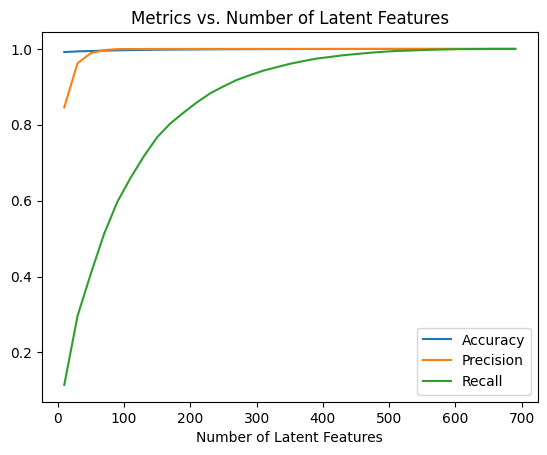

In [55]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

I would choose 300 latent features, as this provides a strong balance between accuracy, precision, and recall while avoiding unnecessary model complexity. The gains in recall beyond this point are marginal, and precision/accuracy have already saturated.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [56]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Ensure article_id is in the user_item columns
    if article_id not in user_item.columns:
        raise ValueError(f"Article ID {article_id} not found in user-item matrix.")
    
    # Get the index of the article in the user_item matrix (column index)
    article_idx = list(user_item.columns).index(article_id)

    # Transpose vt to get articles x latent_features matrix
    article_latent = vt.T  # shape: (num_articles, num_latent_features)

    # Compute cosine similarities between this article and all others
    cos_sim = cosine_similarity([article_latent[article_idx]], article_latent).flatten()

    # Get sorted indices of similar articles, excluding the article itself
    sorted_indices = np.argsort(cos_sim)[::-1]
    sorted_indices = [i for i in sorted_indices if i != article_idx]

    # Map indices back to article_ids
    article_ids = list(user_item.columns)
    most_similar_ids = [article_ids[i] for i in sorted_indices[:10]]

    if include_similarity:
        most_similar_items = [[article_ids[i], cos_sim[i]] for i in sorted_indices[:10]]
        return most_similar_items

    return most_similar_ids

In [57]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [58]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [59]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [60]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['country statistics: crude oil - exports',
 'airbnb data for analytics: athens reviews',
 'use spark r to load and analyze data',
 'country statistics: crude oil - proved reserves',
 'top analytics tools in 2016',
 'airbnb data for analytics: paris calendar',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 'advancements in the spark community',
 'collecting data science cheat sheets']

In [61]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 


**Using matrix factorization** with SVD allowed us to uncover latent relationships between users and articles by projecting both into a shared lower-dimensional space. In this space, we can identify articles similar in terms of collaborative behavior, rather than just title content or frequency of views.

For example, using 200 latent features, we were able to recommend articles that users with similar interaction histories also engaged with — this provides a form of collaborative filtering that captures more nuanced patterns than simple co-occurrence.

***User Scenarios***

**New Users (No History)** :
    Use Rank-Based or Content-Based methods (e.g., top popular articles, or recommend by article cluster/title similarity).

**Cold Start Users (Minimal History)**:
    Use a hybrid approach:

- Rank-based + content-based based on last seen article

- Fallback to collaborative filtering if possible

**Established Users (Lots of History)**:
    Use SVD-based or user-user collaborative filtering — these leverage full interaction patterns and offer the best personalization.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [62]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb', '--to', 'pdf'])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to pdf
[NbConvertApp] Support files will be in Recommendations_with_IBM_files/
[NbConvertApp] Making directory ./Recommendations_with_IBM_files
[NbConvertApp] Writing 153452 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 235071 bytes to Recommendations_with_IBM.pdf


0